# Exploratory Analysis - Data Story

## Data Preparation Summary
I'll start by doing a quick summary of the data preparation steps that have been undertaken up to this point. 

* Raw data gathered and cleaned of unnecessary columns
* 2000 census tracts were converted to 2010 census tracts using population relationships
* Binned variables condensed into a single index value
* Monetary variables adjusted for inflation relative to 2016
* Population variables converted to percentages
* Rent index imputed for missing values
* Special neighborhoods that don't fit study were removed

So now my cleaned and prepped dataset contains 343 neighborhoods (a.k.a. census tracts or geoids) spanning 9 years (2000 and 2009-2016) for a total of 3,087 observations with 6 features per neighborhood.

## High-Level Feature Comparisons
For this section, all observations will be investigated together, independent of the year they were collected. This can be done since the data has been adjusted for inflation, indexed, and converted to per capita proportions. Later we will see how each feature and neighborhood changes over time.

In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import os
import pickle
# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import mapping libraries
from cartopy.io.shapereader import Reader
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, ColorMapper
from bokeh.io import output_notebook, show, save
from bokeh.plotting import figure
from bokeh.palettes import RdBu11 as palette
from bokeh.models.widgets import Panel, Tabs
from bokeh.resources import CDN
# import HTML to show the bokeh plot
from IPython.display import HTML
# make the plots inline
%matplotlib inline

In [2]:
# load the pickled data
pickle_data = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'clean_data.pickle'), 'rb')
data = pickle.load(pickle_data)
# create a column variable and proper column names
cols = data.columns[1:]
names = ['Income Index', 'Education Index', 'Percent White', 
         'Rent Index', 'Value Index', 'Percent Employed']
# do a quick describe on the data
data[data.columns[1:]].describe()

income_index  education_index  white_alone   rent_index   value_index  \
count    3087.000000      3087.000000  3087.000000  3087.000000  3.087000e+03   
mean    84574.721441         4.469174     0.762738  1193.188329  2.488047e+05   
std     35102.422445         0.863623     0.152080   315.263522  1.441974e+05   
min     13706.377011         2.288828     0.124507   494.460416  3.834124e+04   
25%     59655.871428         3.799704     0.672536   979.597039  1.560197e+05   
50%     77301.815619         4.548594     0.800683  1134.887348  2.046165e+05   
75%    100769.649306         5.134217     0.875675  1347.973479  2.918180e+05   
max    251933.727125         6.272527     0.992427  3153.470306  1.079152e+06   

          employed  
count  3087.000000  
mean      0.937733  
std       0.036984  
min       0.719956  
25%       0.919896  
50%       0.944004  
75%       0.963016  
max       1.000000

In [3]:
print('Number of neighborhoods: {}'.format(len(data.index.unique())))
print('Number of years: {}'.format(len(data['year'].unique())))
print('Number of observations: {}'.format(len(data)))

Number of neighborhoods: 343
Number of years: 9
Number of observations: 3087


In [4]:
# create a col variable for easier indexing
cols = data.columns[1:]
# make list of proper column descriptors
names = ['Income Index', 'Education Index', 'Percent White', 
         'Rent Index', 'Value Index', 'Percent Employed']

### Correlation Matrix
I'll start by seeing how correlated each of the features is to each other.

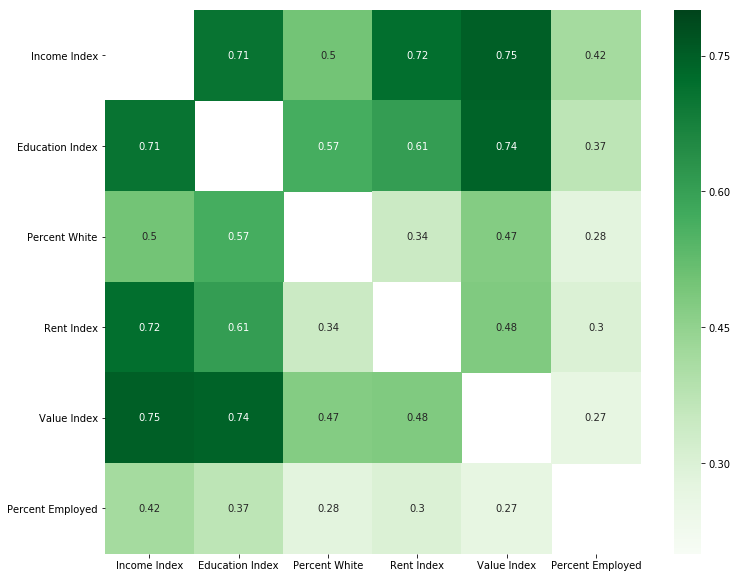

In [5]:
# create the correlation matrix
corr = data[cols].corr()
# create mask for diagonal (self correlations)
mask = corr == 1
# make the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# plot the heatmap of correlations
_ = sns.heatmap(corr, cmap='Greens', vmax=0.8, vmin=0.2, annot=True, ax=ax, 
                xticklabels=names, yticklabels=names, mask=mask)

From the above correlation matrix, we can see that all features have positive correlations between 0.27 and 0.75. Education attained shows high correlation with income and home value (0.71 and 0.74 respectively) which is not surprising since higher education typically leads to higher household income which in turn leads to the ability to purchase more expensive housing. Rent and income show similar correlation.

I am surprised to see that the correlation between rent and home value is not higher than 0.48. My intuition would be that neighborhoods with higher home values would also be neighborhoods where rent is high. Perhaps this is reflective of the large number of neighborhoods which intermingle residential housing and apartment complexes. 

Another interesting point that opposes my initial expectations is that there is very low correlation between the employment percentage of a neighborhood and the home value even though the correlation between employment rate and income is moderate. Thinking a bit deeper, I can reason how neighborhoods with the highest employment rate would probably not coincide with either the lowest or highest home values. On one hand, I don't expect neighborhoods with the lowest home values to have full employment because of higher likelihood of a lack of education and substance abuse. Similarly, neighborhoods with the highest home values probably have a large portion of the population that are independently wealthy or comfortably retired, which don't need to work. 

I'll take a closer look at each one of these relationships a bit later.

### Scatter Matrix
While correlation gives a good initial idea of how the features relate to each other, a scatter matrix will give finer relationship details between features. Additionally, the distribution of each feature can be easily visualized with a single line of code.

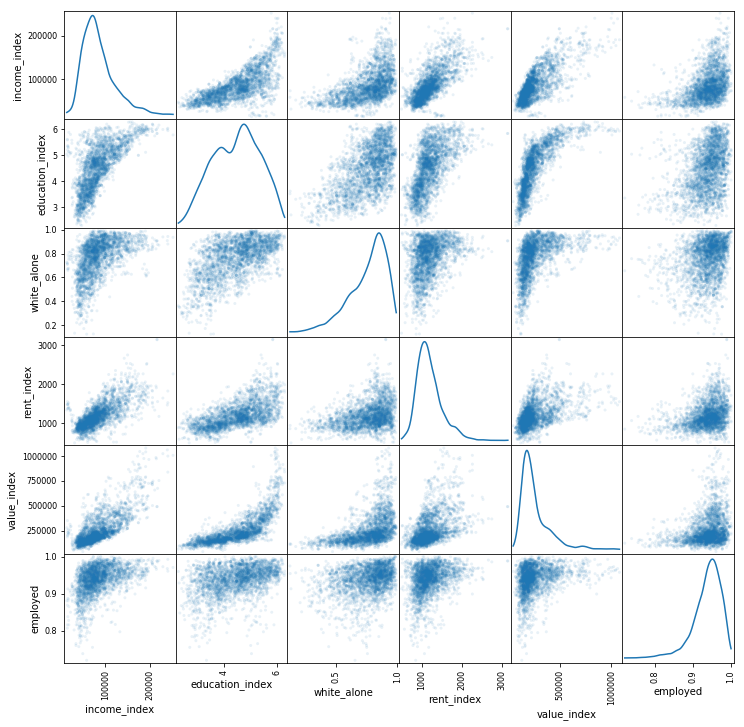

In [6]:
_ = pd.plotting.scatter_matrix(data[cols], figsize=(12, 12), alpha=0.1, diagonal='kde', marker='.')

Now we can start to see some of the intricate relationships between the features. Subplots with a large spread in scatter points have a weaker relationship than subplots with tight grouping of points. By using a very low alpha (transparency) value for each point, the darkest color appears where many points overlap. This dark section of each subplot is where the relationship between the features is the most common. For example, the scatter plot of rent versus home value has a very dark region in the lower left corner in which most of the points fall. Beyond that, the relationship gets weaker and point are more spread out, thus the color is lighter. Subplots with a less pronounced dark region represent features with a weak relationship which tend to have a greater spread in scatter points (as seen in the education vs percentage white subplot).

### Select Feature Comparisons
In this section I'll pick a few of the most interesting feature relationships to explain in greater depth. For the comparisons I'll be using a combination of scatterplots, histograms, and kernel density estimation contours. Seaborn offers an information rich combination plot which is perfect for this sort of comparison.

#### Income vs Home Value

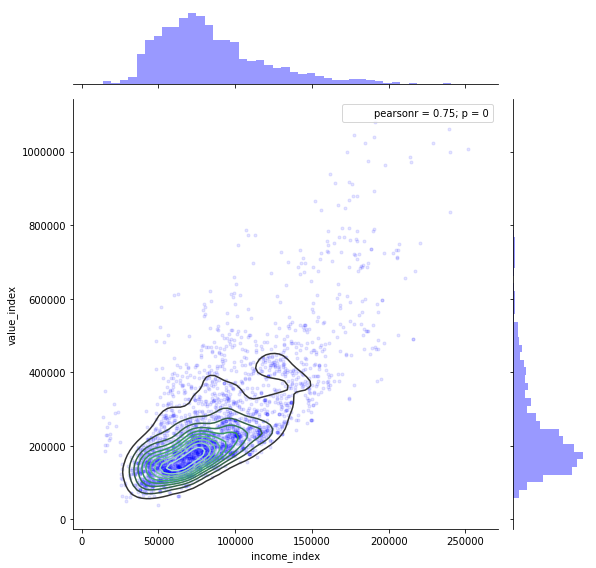

In [7]:
_ = sns.jointplot(x='income_index', y='value_index', data=data, size=8,
                  joint_kws={'alpha': 0.1, 'marker': '.'}, color='b') \
       .plot_joint(sns.kdeplot, zorder=2)

There is clearly a linear relationship between income and home value, which is not surprising. The lower bound of this linear relationship is very pronounced while the upper bound is more variable. Some outliers in this plot show relationships between income and home value that don't make much sense. For instance, in the lower left-hand corner there are a group of observations that fall outside the density contours that have the lowest income (<\$20k) but comparatively high home values (\$200k - \$300k). How could this be? 

In [8]:
display(data.sort_values(by='income_index').head(20))

year  income_index  education_index  white_alone   rent_index  \
geoid                                                                        
48453000604  2015  13706.377011         5.031646     0.727299  1339.641269   
48453000603  2011  14972.318887         5.598698     0.722643  1482.178483   
48453000604  2016  15229.476406         5.196850     0.711692  1373.399183   
48453000603  2012  15249.196908         5.579088     0.712119  1553.681437   
48453000603  2015  15766.377718         5.358566     0.671663  1471.297923   
48453000603  2016  16199.134199         5.308005     0.658758  1495.461747   
48453000603  2014  16206.741820         5.337192     0.670000  1482.025274   
48453000604  2013  16734.814069         4.955247     0.788213  1381.704942   
48453000604  2014  17544.257384         5.276768     0.752645  1392.132567   
48453000603  2013  17871.586888         5.122020     0.676134  1522.245235   
48453000603  2010  18369.334825         5.870968     0.772396  1416.158511   
48453000604  2012  18542.410221         5.129310     0.810351  1377.013181   
48453000604  2010  20999.549978         5.071429     0.751494  1317.179016   
48453000604  2011  21738.796373         5.038718     0.777623  1354.482548   
48453000603  2009  22064.165563         5.788644     0.814123  1333.509154   
48453000604  2009  23478.109088         5.094203     0.783907  1216.447727   
48453000604  2000  25023.925839         5.566016     0.749183  1076.678197   
48453000603  2000  25254.545352         5.448417     0.800683  1043.167293   
48453002317  2012  25335.334927         3.351510     0.441762  1060.912555   
48453002317  2011  25783.191993         3.060847     0.399576  1124.942116   

               value_index  employed  
geoid                                 
48453000604  277707.866697  0.880977  
48453000603  185330.990778  0.806953  
48453000604  350000.000000  0.869003  
48453000603  202620.209454  0.815954  
48453000603  230313.039427  0.886992  
48453000603  251939.655172  0.913009  
48453000603  202859.991567  0.837962  
48453000604  229134.917713  0.880944  
48453000604  262413.744805  0.885968  
48453000603  215255.241009  0.827938  
48453000603  233349.182996  0.815923  
48453000604  222531.054704  0.865033  
48453000604  312739.477273  0.909017  
48453000604  288844.735474  0.904014  
48453000603  254543.911497  0.849945  
48453000604  292375.691591  0.894940  
48453000604  209588.684729  0.923943  
48453000603  175972.291868  0.914138  
48453002317  123579.967418  0.920053  
48453002317   94376.818231  0.927917

It turns out that all of these points belong to two neighborhoods (48453000603 and 48453000604) which are located directly West of the University of Texas campus and have a large student population. The student population drives the income index down while the disirable geographic location drives home values up. 

### Education vs Income

To understand this relationship I need to explain how the education index was calculated. Education attained was originally a binned ordinal variable which was converted into an index using a simple scoring method. The scores for each level of attained education are described below:

1 - Less than 9th grade  
2 - Some high school  
3 - Graduated high school  
4 - Some college  
5 - Associate's degree  
6 - Bachelor's degree  
7 - Graduate degree (includes doctorate and professional degrees)

So an education index of 5 means that the average education attained for a neighborhood would be an associates degree. Now, we can move forward with the comparison.

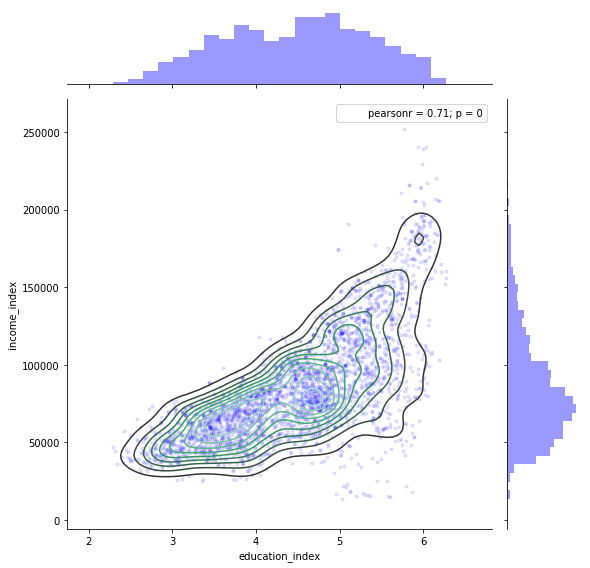

In [9]:
_ = sns.jointplot(x='education_index', y='income_index', data=data, size=8,
                  joint_kws={'alpha': 0.1, 'marker': '.'}, color='b') \
       .plot_joint(sns.kdeplot, zorder=2)

While there is clearly a positive psuedo-linear relationship between education attained and income, there seems to be a breakpoint around an education index of 5 (which corresponds to associate's degree attainment). To the right of this breakpoint, income is much more variable although the potential maximum income is much higher in comparison to lower education attainment. As in the previous comparison of income to home value, the cluster of points at the bottom right of the plot (high education, low income) correspond to neighborhoods with large percentages of students.

#### Home Value vs Percentage White

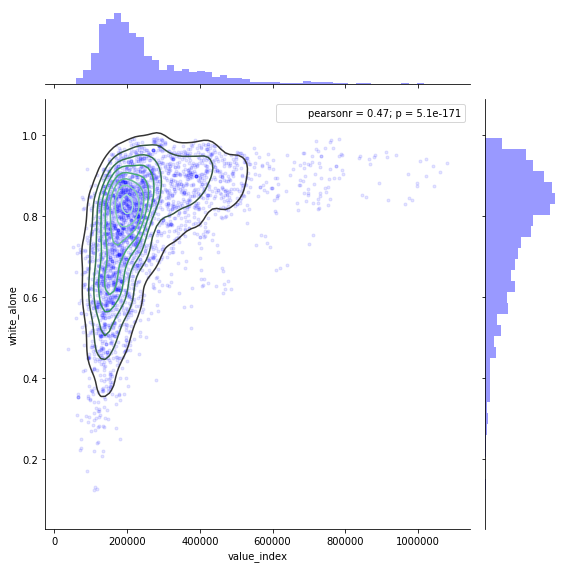

In [10]:
_ = sns.jointplot(x='value_index', y='white_alone', data=data, size=8,
                  joint_kws={'alpha': 0.1, 'marker': '.'}, color='b') \
       .plot_joint(sns.kdeplot, zorder=2)

This plot alone tells a very profound socioeconomic story about Austin. While the city boasts about racial equality and affordability, they fail to tell you as these things are apparently mutually exclusive. For instance, the top 100 neighborhoods in terms of home value are nearly 90% white! I've personally driven through many of these neighborhoods and can attest to their monochromatic demographics. 

In [11]:
print('100 Highest Neighborhood Home Values - {:.2f}% White'.format(
data.sort_values(by='value_index', ascending=False).iloc[:100]['white_alone'].mean()* 100))

100 Highest Neighborhood Home Values - 89.08% White


## Neighborhood Change Over Time

In [12]:
changes_2000_2016 = data[data['year'] == '2016'][cols] \
                    - data[data['year'] == '2000'][cols]
changes_2000_2016.describe()

income_index  education_index  white_alone   rent_index    value_index  \
count    343.000000       343.000000   343.000000   343.000000     343.000000   
mean   -4849.697607         0.257668     0.057834    61.012248   62015.106784   
std    17968.878265         0.460806     0.144083   288.696810   81597.725009   
min   -71939.649925        -1.025745    -0.259872 -1637.266622 -408007.709788   
25%   -13984.298247        -0.003759    -0.035993   -68.485701   16199.704642   
50%    -5956.814555         0.229539     0.019662    40.262056   45842.213994   
75%     5086.378057         0.451697     0.135156   222.116310   96707.885621   
max    40539.910936         1.850866     0.554877  1382.390207  360743.701625   

         employed  
count  343.000000  
mean    -0.026552  
std      0.029864  
min     -0.163559  
25%     -0.042258  
50%     -0.024418  
75%     -0.008354  
max      0.062651

In [13]:
# get unique geoids in data
geoids = list(set(data.index))
# read the shapefile
tracts = Reader(os.path.join('..', 'shapefiles', 'austin_metro_tracts.shp'))
# extract the x's and y's (bokeh preferred format is list of lists)
xs, ys, names, tract = [], [], [], []
for r, g in zip(tracts.records(), tracts.geometries()):
    if int(r.attributes['GEOID']) in geoids:
        xs.append(list(g[0].exterior.coords.xy[0]))
        ys.append(list(g[0].exterior.coords.xy[1]))
        names.append(int(r.attributes['GEOID']))
        tract.append(float(r.attributes['GEOID'][-6:]) / 100)
# set up the color mapper
color_mapper = LinearColorMapper(palette=palette)
# choose which bokeh tools are included
TOOLS = 'pan, wheel_zoom, hover, reset, save'

In [14]:
def make_source(var):
    '''make the source for the selected variable for the map'''
    source = ColumnDataSource(data=dict(
        x=xs,
        y=ys,
        name=names,
        tract=tract,
        p_var = changes_2000_2016.loc[names, var].tolist()
    ))
    return source

def make_tab(title, var):
    '''make the tab for the selected variable for the map'''
    p = figure(title='{} Change from 2000 to 2016'.format(title), tools=TOOLS, 
               x_axis_location=None, y_axis_location=None)
    r = p.patches('x', 'y', source=make_source(var), 
                  fill_color={'field': 'p_var', 'transform': color_mapper},
                  fill_alpha=0.5, line_color='black', line_width=0.5)
    h = p.select_one(HoverTool)
    h.point_policy = 'follow_mouse'
    h.tooltips = [
        ('GeoID', '@name'),
        ('Census Tract', '@tract'),
        ('Lon, Lat', '$x, $y'),
        ('{} Change'.format(title), '@p_var{0,0.11}')
    ]
    tab = Panel(child=p, title=title)
    return tab

In [22]:
# create lists for titles and variable (column) names
ts = ['Income', 'Home Value', 'Rent', 'Education', 'Percent White', 'Percent Employed']
vs = ['income_index', 'value_index', 'rent_index', 'education_index', 'white_alone', 'employed']
# create list to hold the tabs for each variable
tabs = [make_tab(t, v) for t, v in zip(ts, vs)]
# create the tabs widget    
T = Tabs(tabs=tabs)
# save the map as HTML
save(T, filename='./change_viewer.html', title='Changes from 2000 to 2016', 
         resources=CDN)


'/Users/tsansom/springboard/capstone_projects/gentrification/writeups/change_viewer.html'

In [26]:
# now display the map
HTML(filename='./change_viewer.html')